In [1]:
#######################################################
#######################################################
############    COPYRIGHT - DATA SOCIETY   ############
#######################################################
#######################################################

## OUTLIER DETECTION DAY 2/OUTLIER DETECTION PART 3 ##

## NOTE: To run individual pieces of code, select the line of code and
##       press ctrl + enter for PCs or command + enter for Macs




In [2]:
#=================================================-
#### Slide 26: Loading packages  ####

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest




In [3]:
#=================================================-
#### Slide 27: Directory settings  ####

# Set 'main_dir' to location of the project folder
from pathlib import Path 
home_dir = Path(".").resolve()
main_dir = home_dir.parent
print(main_dir)
data_dir = str(main_dir) + "/data"
print(data_dir)




/Users/swaroopnc/Downloads/SkillAnamoly2025
/Users/swaroopnc/Downloads/SkillAnamoly2025/data


In [4]:
#=================================================-
#### Slide 28: Load the dataset  ####

paysim = pd.read_csv(str(data_dir)+"/paysim_transactions.csv")
paysim.head()




step      type      amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0   308  CASH_OUT    94270.99   C473084216            0.0             0.0   
1   215  TRANSFER  1068883.00   C116497934          227.3             0.0   
2   326  TRANSFER  2485281.21  C2089305953        54940.0             0.0   
3   371   PAYMENT     2243.36  C1200351076            0.0             0.0   
4   283   PAYMENT     5845.82  C1501258365            0.0             0.0   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  C1130422007       392411.08       486682.07        0               0  
1   C321541184      4096905.34      5165788.35        0               0  
2  C1473680645       177829.59      2663110.80        0               0  
3  M1583169191            0.00            0.00        0               0  
4  M1431167213            0.00            0.00        0               0

In [5]:
#=================================================-
#### Slide 29: Prepare the dataset for modeling  ####

# Drop columns. 
paysim = paysim.drop(['step', 'type','nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)
paysim.columns




Index(['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud'],
      dtype='object')

In [6]:
#================================================= -
#### Slide 30: LOF on fraud dataset  ####

# Stratified split
X = paysim[['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]
y = paysim['isFraud']
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=1)

# Isolate non‑fraud for LOF training
X_train = X_train_full[y_train_full == 0]

# 3) <b>Scale data</b> (Euclidean distance requires scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)




In [7]:
#================================================= -
#### Slide 31: What does `novelty=True` do?  ####

# Unsupervised mode (no novelty) — predict on new data will error:
lof_unsup = LocalOutlierFactor(n_neighbors=5, novelty=False)
# lof_unsup.predict(X_test_scaled)  # ← Not allowed

# Novelty mode — fit on inliers, then predict on new samples:
lof_sup = LocalOutlierFactor(n_neighbors=5, contamination=0.1, novelty=True)
lof_sup.fit(X_train_scaled)
_ = lof_sup.predict(X_test_scaled)  # Valid




In [8]:
#=================================================-
#### Slide 32: Create and fit LOF model  ####

lof = LocalOutlierFactor(
    n_neighbors=5,
    contamination=0.1,
    novelty=True
)
lof.fit(X_train_scaled)




LocalOutlierFactor(contamination=0.1, n_neighbors=5, novelty=True)

In [9]:
#=================================================-
#### Slide 33: Test predictions  ####

y_pred = lof.predict(X_test_scaled)

# Map: -1→1 (fraud), +1→0 (normal)
y_pred = np.where(y_pred == -1, 1, 0)




In [10]:
#================================================= -
#### Slide 34: Find TPR and TNR  ####

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
non_fraud_eval = tn / (tn + fp)
print(non_fraud_eval)
fraud_eval = tp / (tp + fn)
print(fraud_eval)




0.8981666666666667
0.6515151515151515


In [11]:
#=================================================-
#### Slide 35: Load performance_df dataframe  ####

performance_df = pickle.load(open(str(data_dir) + "/performance_anomalies.sav", "rb"))  
# append the new row for LOF
s = pd.Series(
    ['LOF', fraud_eval, non_fraud_eval],
    index=['model_name', 'TPR', 'TNR']
)

performance_df = pd.concat([performance_df, s.to_frame().T], ignore_index=True)
performance_df




model_name       TPR       TNR
0  Decision_tree_baseline  0.671642  0.999667
1                   SMOTE  0.850746  0.992499
2                     LOF  0.651515  0.898167

In [12]:
#=================================================-
#### Slide 36: Exercise 1  ####






In [13]:
#================================================= -
#### Slide 40: LOF model - tuning neighborhood size  ####

results = []
for n in range(3, 21):
    lof_n = LocalOutlierFactor(n_neighbors=n, contamination=0.1, novelty=True)
    lof_n.fit(X_train_scaled)
    pred_n = np.where(lof_n.predict(X_test_scaled) == -1, 1, 0)
    tn, fp, fn, tp = confusion_matrix(y_test, pred_n).ravel()
    results.append((n, tp/(tp+fn), tn/(tn+fp)))

lof_df = pd.DataFrame(results, columns=['n_neighbors','TPR','TNR'])




In [14]:
#================================================= -
#### Slide 41: LOF model - tuning neighborhood size  ####

plt.figure(figsize=(5,5))
plt.plot(lof_df['n_neighbors'], lof_df['TNR'], label='TNR')
plt.plot(lof_df['n_neighbors'], lof_df['TPR'], label='TPR')
plt.xlabel('Neighbor')
plt.ylabel('Score')
plt.legend(loc="lower right")
plt.show()




In [15]:
#================================================= -
#### Slide 42: LOF model - tuning contamination  ####

cont_vals = [0.01,0.03,0.05,0.1,0.2,0.3]
results = []
for c in cont_vals:
    lof_c = LocalOutlierFactor(n_neighbors=14, contamination=c, novelty=True)
    lof_c.fit(X_train_scaled)
    pred_c = np.where(lof_c.predict(X_test_scaled)==-1, 1, 0)
    tn, fp, fn, tp = confusion_matrix(y_test, pred_c).ravel()
    results.append((c, tp/(tp+fn), tn/(tn+fp)))

cont_df = pd.DataFrame(results, columns=['contamination','TPR','TNR'])




In [16]:
#================================================= -
#### Slide 43: LOF model - tuning contamination  ####

plt.plot(cont_df['contamination'], cont_df['TPR'], label='TPR')
plt.plot(cont_df['contamination'], cont_df['TNR'], label='TNR')
plt.xlabel('contamination')
plt.legend(loc='lower right')
plt.show()




In [17]:
#================================================= -
#### Slide 44: Optimized LOF model  ####

lof_opt = LocalOutlierFactor(
    n_neighbors=14, contamination=0.2, novelty=True
)
lof_opt.fit(X_train_scaled)




LocalOutlierFactor(contamination=0.2, n_neighbors=14, novelty=True)

In [18]:
#=================================================-
#### Slide 45: Test predictions  ####

y_opt = np.where(lof_opt.predict(X_test_scaled)==-1, 1, 0)
tn, fp, fn, tp = confusion_matrix(y_test, y_opt).ravel()
non_fraud_eval = tn / (tn + fp)
print(non_fraud_eval)
fraud_eval = tp / (tp + fn)
print(fraud_eval)




0.8
0.8181818181818182


In [19]:
#=================================================-
#### Slide 46: Add scores to the performance dataframe  ####

# append the new row for LOF
s2 = pd.Series(
    ['LOF_optimised', fraud_eval, non_fraud_eval],
    index=['model_name', 'TPR', 'TNR']
)

performance_df = pd.concat([performance_df, s2.to_frame().T], ignore_index=True)
performance_df




model_name       TPR       TNR
0  Decision_tree_baseline  0.671642  0.999667
1                   SMOTE  0.850746  0.992499
2                     LOF  0.651515  0.898167
3           LOF_optimised  0.818182       0.8

In [20]:
#=================================================-
#### Slide 48: Exercise 2  ####






In [21]:
#=================================================-
#### Slide 50: Save results as a pickle  ####

pickle.dump(performance_df, open(str(data_dir) + "/performance_anomalies.sav","wb"))
pickle.dump(X_train_scaled, open(str(data_dir) + "/X_train_scaled.sav","wb"))
pickle.dump(X_test_scaled, open(str(data_dir) + "/X_test_scaled.sav","wb"))
pickle.dump(y_test, open(str(data_dir) + "/y_test.sav","wb"))


#######################################################
####  CONGRATULATIONS ON COMPLETING THIS MODULE!   ####
#######################################################


In [22]:
#######################################################
#######################################################
############    COPYRIGHT - DATA SOCIETY   ############
#######################################################
#######################################################

## OUTLIER DETECTION DAY 2/OUTLIER DETECTION PART 4 ##

## NOTE: To run individual pieces of code, select the line of code and
##       press ctrl + enter for PCs or command + enter for Macs




In [23]:
#=================================================-
#### Slide 2: Loading packages  ####

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import StandardScaler  
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest




In [24]:
#=================================================-
#### Slide 3: Directory settings  ####

# Set 'main_dir' to location of the project folder
from pathlib import Path 
home_dir = Path(".").resolve()
main_dir = home_dir.parent
print(main_dir)
data_dir = str(main_dir) + "/data"
print(data_dir)




/Users/swaroopnc/Downloads/SkillAnamoly2025
/Users/swaroopnc/Downloads/SkillAnamoly2025/data


In [25]:
#=================================================-
#### Slide 4: Load pickled data from previous module  ####

performance_df = pickle.load(open(str(data_dir)+"/performance_anomalies.sav","rb"))  
X_train_scaled = pickle.load(open(str(data_dir)+"/X_train_scaled.sav","rb")) 
X_test_scaled = pickle.load(open(str(data_dir)+"/X_test_scaled.sav","rb")) 
y_test = pickle.load(open(str(data_dir)+"/y_test.sav","rb")) 




In [26]:
#=================================================-
#### Slide 5: Data: load energy consumption  ####

pjm_energy = pd.read_csv(str(data_dir)+"/PJME_hourly.csv")
pjm_energy.head()




Datetime  PJME_MW
0  2002-12-31 01:00:00  26498.0
1  2002-12-31 02:00:00  25147.0
2  2002-12-31 03:00:00  24574.0
3  2002-12-31 04:00:00  24393.0
4  2002-12-31 05:00:00  24860.0

In [27]:
#=================================================-
#### Slide 6: Data: preprocessing  ####

pjm_energy['Datetime'] = pd.to_datetime(pjm_energy['Datetime'])
pjm_energy.info()
pjm_energy = pjm_energy[pjm_energy['Datetime'] > '2018-01-01 00:00:00']
pjm_energy.shape




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  145366 non-null  datetime64[ns]
 1   PJME_MW   145366 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 MB


(5135, 2)

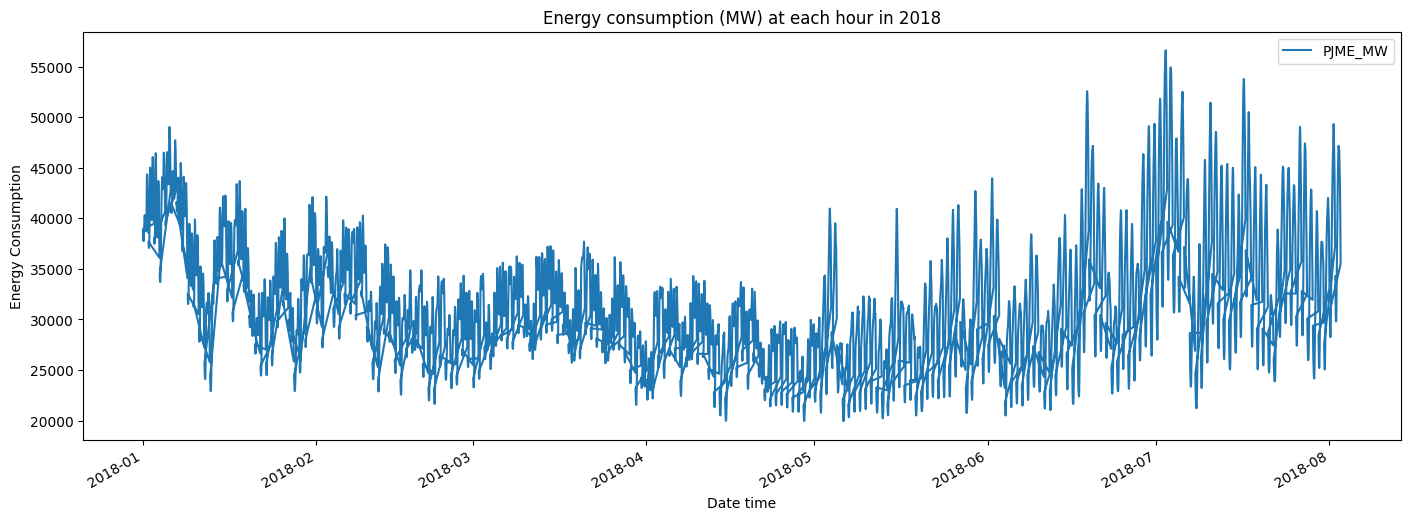

In [28]:
#=================================================-
#### Slide 7: Visualize the data: line plot  ####

pjm_energy.plot(x='Datetime', y='PJME_MW', figsize=(17,6))
plt.xlabel('Date time')
plt.ylabel('Energy Consumption')
plt.title('Energy consumption (MW) at each hour in 2018')
plt.show()




In [29]:
#=================================================-
#### Slide 9: Create and fit LOF model: energy consumption  ####

lof_energy_model = LocalOutlierFactor(n_neighbors = 50, 
                                      contamination = 0.01, 
                                      novelty = False)
                                      
pjm_energy['anomaly'] = lof_energy_model.fit_predict(pd.DataFrame(pjm_energy['PJME_MW']))




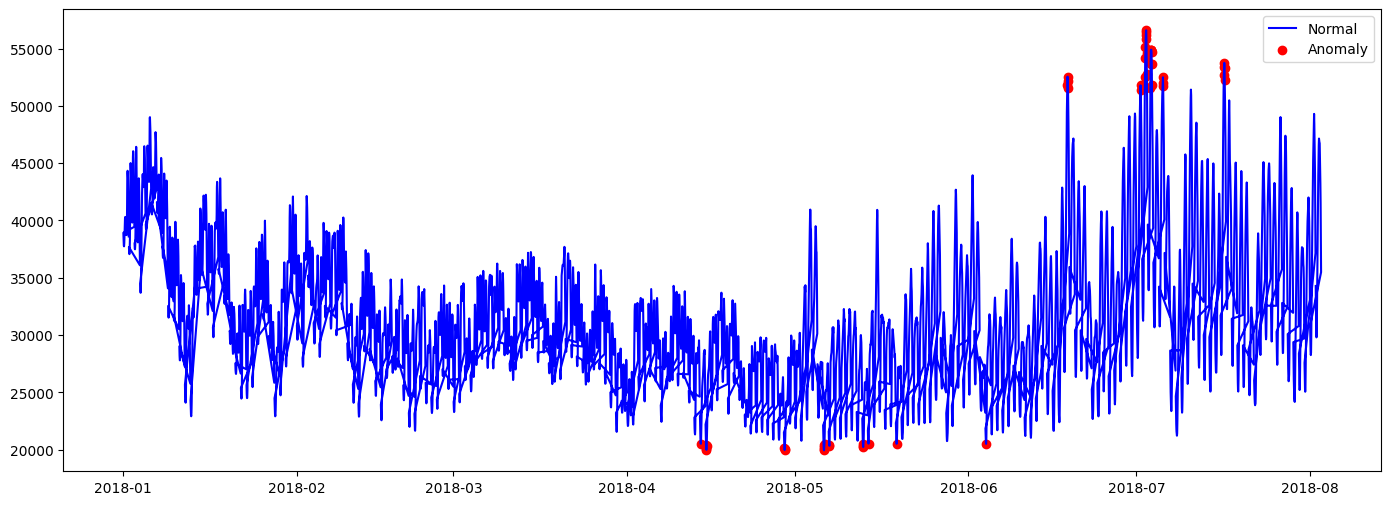

In [30]:
#=================================================-
#### Slide 10: LOF - visualize anomalies  ####

# visualization
fig, ax = plt.subplots(figsize=(17,6))

a = pjm_energy.loc[pjm_energy['anomaly'] == -1, ['Datetime', 'PJME_MW']] #anomaly

ax.plot(pjm_energy['Datetime'], pjm_energy['PJME_MW'], color='blue', label = 'Normal')
ax.scatter(a['Datetime'],a['PJME_MW'], color='red', label = 'Anomaly')
plt.legend()
plt.show();




In [31]:
#=================================================-
#### Slide 11: LOF - visualize anomalies  ####

lower_threshold = pjm_energy['PJME_MW'].quantile(0.25)
upper_threshold = pjm_energy['PJME_MW'].quantile(0.75)
lof_anomalies = pjm_energy[pjm_energy['anomaly'] == -1]
# Upper range of anomalies
lof_upper_anomalies = lof_anomalies[lof_anomalies['PJME_MW'] > upper_threshold]['PJME_MW']

# Lower range of anomalies
lof_lower_anomalies = lof_anomalies[lof_anomalies['PJME_MW'] < lower_threshold]['PJME_MW']




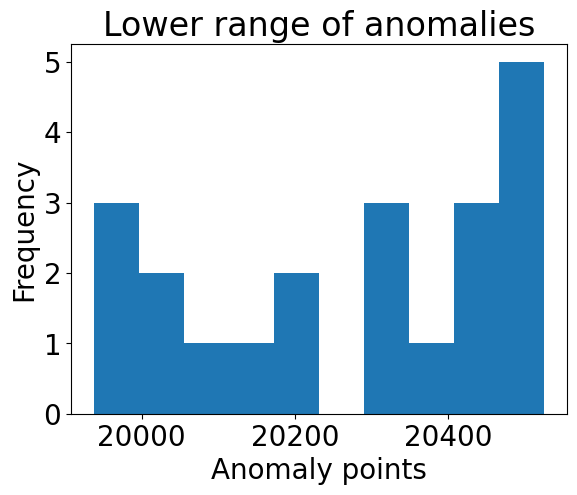

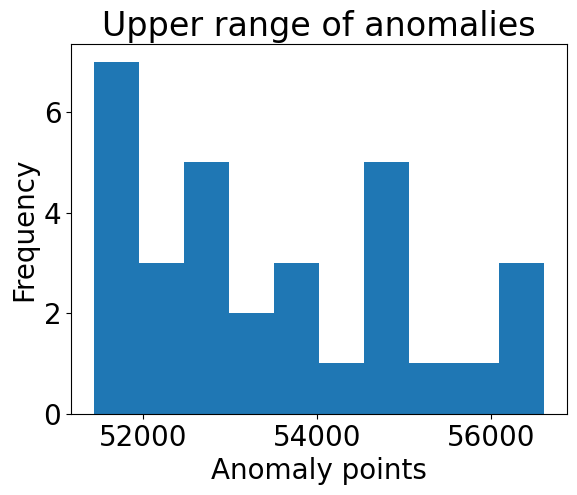

In [32]:
#=================================================-
#### Slide 12: LOF - visualize anomalies  ####

plt.rcParams.update({'font.size': 20})
plt.hist(lof_lower_anomalies)
plt.xlabel("Anomaly points")
plt.ylabel("Frequency")
plt.title("Lower range of anomalies")
plt.show()
plt.hist(lof_upper_anomalies)
plt.xlabel("Anomaly points")
plt.ylabel("Frequency")
plt.title("Upper range of anomalies")
plt.show()




In [33]:
#=================================================-
#### Slide 13: Exercise 3  ####






In [34]:
#=================================================-
#### Slide 24: Create and fit isolation forest model  ####

iforest = IsolationForest(n_estimators=100, contamination = 0.1)

# model fitting
iforest.fit(X_train_scaled)




IsolationForest(contamination=0.1)

In [35]:
#=================================================-
#### Slide 25: Test predictions  ####

fraud_pred = iforest.predict(X_test_scaled)
fraud_pred
fraud_pred[fraud_pred == 1] = 0
fraud_pred[fraud_pred == -1] = 1




In [36]:
#================================================= -
#### Slide 26: Find TPR and TNR  ####

tn, fp, fn, tp = confusion_matrix(y_test, fraud_pred).ravel()
non_fraud_eval = tn / (tn + fp)
print(non_fraud_eval)
fraud_eval = tp / (tp + fn)
print(fraud_eval)




0.8978333333333334
0.10606060606060606


In [37]:
#=================================================-
#### Slide 27: Load performance_df dataframe  ####

s3 = pd.Series(
    ['Isolation Forest', fraud_eval, non_fraud_eval],
    index=['model_name', 'TPR', 'TNR']
)

performance_df = pd.concat([performance_df, s3.to_frame().T], ignore_index=True)
performance_df




model_name       TPR       TNR
0  Decision_tree_baseline  0.671642  0.999667
1                   SMOTE  0.850746  0.992499
2                     LOF  0.651515  0.898167
3           LOF_optimised  0.818182       0.8
4        Isolation Forest  0.106061  0.897833

In [38]:
#=================================================-
#### Slide 30: Exercise 4  ####






In [39]:
#=================================================-
#### Slide 32: Isolation forest on time series data  ####

isolation_energy = IsolationForest(n_estimators=100, contamination = 0.01)

# model fitting
isolation_energy.fit(pd.DataFrame(pjm_energy['PJME_MW']))
pjm_energy['anomaly'] = isolation_energy.predict(pd.DataFrame(pjm_energy['PJME_MW']))




In [40]:
#=================================================-
#### Slide 33: Isolation forest - visualize anomalies  ####


# visualization
fig, ax = plt.subplots(figsize=(15,5))

a = pjm_energy.loc[pjm_energy['anomaly'] == -1, ['Datetime', 'PJME_MW']] #anomaly

ax.plot(pjm_energy['Datetime'], pjm_energy['PJME_MW'], color='blue', label = 'Normal')
ax.scatter(a['Datetime'],a['PJME_MW'], color='red', label = 'Anomaly')
plt.legend()
plt.show()




In [41]:
#=================================================-
#### Slide 34: Isolation forest - visualize anomalies  ####

# visualization
lower_threshold = pjm_energy['PJME_MW'].quantile(0.25)
upper_threshold = pjm_energy['PJME_MW'].quantile(0.75)
if_anomalies = pjm_energy[pjm_energy['anomaly'] == -1]

if_upper_anomalies = if_anomalies[if_anomalies['PJME_MW'] > upper_threshold]['PJME_MW']
if_lower_anomalies = if_anomalies[if_anomalies['PJME_MW'] < lower_threshold]['PJME_MW']




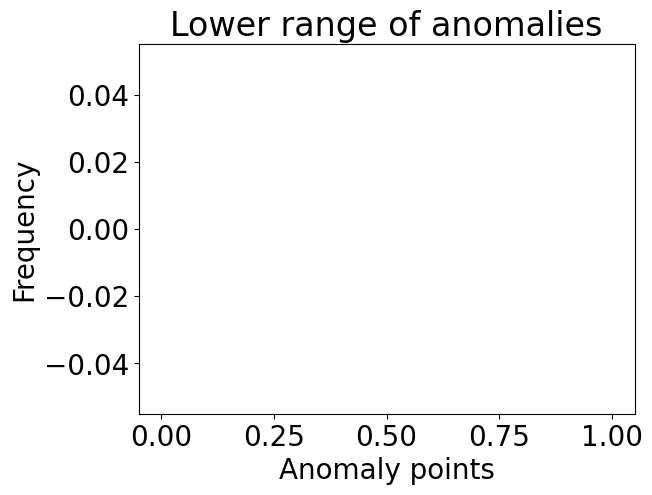

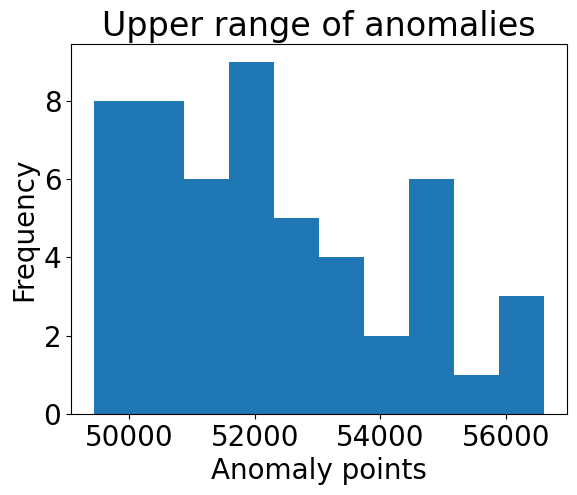

In [42]:
#=================================================-
#### Slide 35: Isolation forest - visualize anomalies  ####

plt.hist(if_lower_anomalies)
plt.xlabel("Anomaly points")
plt.ylabel("Frequency")
plt.title("Lower range of anomalies")
plt.show()
plt.hist(if_upper_anomalies)
plt.xlabel("Anomaly points")
plt.ylabel("Frequency")
plt.title("Upper range of anomalies")
plt.show()




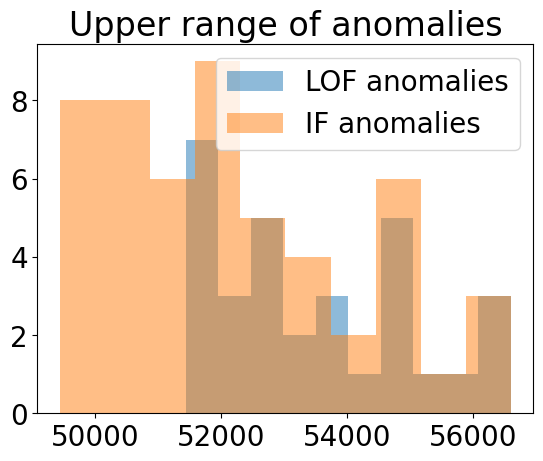

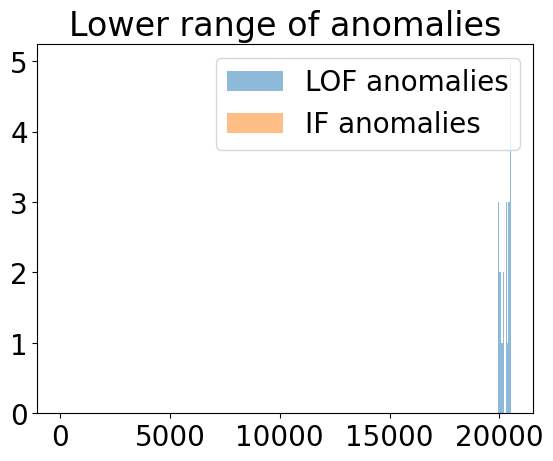

In [43]:
#=================================================-
#### Slide 36: Compare anomalies  ####

plt.hist(lof_upper_anomalies,alpha = 0.5,label='LOF anomalies')
plt.hist(if_upper_anomalies,alpha = 0.5,label='IF anomalies')
plt.title('Upper range of anomalies')
plt.legend(loc='upper right')
plt.show()
plt.hist(lof_lower_anomalies,alpha = 0.5,label='LOF anomalies')
plt.hist(if_lower_anomalies,alpha = 0.5,label='IF anomalies')
plt.title('Lower range of anomalies')
plt.legend(loc='upper right')
plt.show()




In [44]:
#=================================================-
#### Slide 37: Exercise 5  ####




#######################################################
####  CONGRATULATIONS ON COMPLETING THIS MODULE!   ####
#######################################################
